# Vision industrielle - TP 2 

L'objectif de ce TP est de découvrir et d'utiliser des outils d'apprentissage automatique (machine-learning) dans le cadre de la vision par ordinateur. Le langage de programmation Python sera utilisé, ainsi que les librairies scientifiques suivantes:
- NumPy
- SciPy
- matplotlib
- scikit-image
- sklearn

## Objectif : reconnaitre des chiffres et des lettres de façon automatique

Installation des dépendances

In [1]:
# executer cette cellule pour charger l'ensemble des fonctions/librairies utiles
from IPython.core.display import HTML
import requests
#theme_url = "https://raw.githubusercontent.com/ninjasoul/IPython_NB_Config/master/custom.css"
theme_url = "https://raw.githubusercontent.com/ketch/HyperPython/master/custom.css"
rn = requests.get(theme_url)
HTML(rn.text)
from functools import partial
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib notebook
#%matplotlib inline
import pip
pip.main('install imageio'.split())
import imageio
import skimage.morphology
import skimage.segmentation
import skimage.feature


plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.max_open_warning'] = 100
plt.rcParams['figure.figsize'] = 2, 2

def format_coord(x, y, image):
    x = int(x + 0.5)
    y = int(y + 0.5)
    try:
        val = str(image[y, x])
    except IndexError:
        val = "?"
    return "color={} @ [{}, {}]".format(val, y, x)

def display_image_nb(image, title='', cmap=None):
    fig, ax = plt.subplots(1,1)
    if cmap is None:
        ax.matshow(image)
    else:
        ax.matshow(image, cmap=cmap)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    #return fig, ax

def display_image_color(image, title=''):
    fig, ax = plt.subplots(1,1)
    ax.imshow(image)
    ax.set_xlabel(title)
    ax.format_coord = partial(format_coord, image=image)
    #return fig, ax

def draw_rectangle(y1, x1, y2, x2, color='red', ax=None):
    """ Add a rectangle on an image """
    if ax is None:
        ax = plt.gca()
    rect = mpatches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

print("OK let's go")

You are using pip version 7.1.2, however version 8.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


OK let's go


## Introduction: apprentissage automatique

Cette première partie a pour but de vous faire découvrir la librairie sklearn à travers un premier exemple: la reconnaissance de chiffres manuscrits.

### Les données

Dans un premier temps nous chargeons une base d'image de chiffres manuscrits.

Nombre d'image = 1797
Quelques exemples de chiffres présents dans cette base


<IPython.core.display.Javascript object>


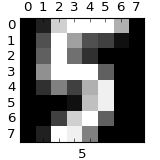

<IPython.core.display.Javascript object>


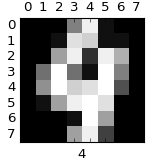

<IPython.core.display.Javascript object>


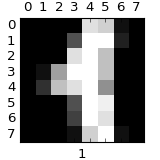

In [2]:
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
digits = sklearn.datasets.load_digits()
print("Nombre d'image = {}".format(digits.data.shape[0]))
print("Quelques exemples de chiffres présents dans cette base")

display_image_nb(digits.images[32], title=digits.target[32])
display_image_nb(digits.images[14], title=digits.target[14])
display_image_nb(digits.images[11], title=digits.target[11])

De combien d'image est constitué le tableau. Quelle est la taille de chaque image ? 

In [3]:
print("Il s'agit d'un tableau de {} images, de tailles {}x{}".format(*digits.images.shape))

Il s'agit d'un tableau de 1797 images, de tailles 8x8


Pour chaque image, nous disposons d'un label correspondant au chiffre présent dans l'image. Ce label est diponnible dans le *tableau digits.target*.

In [4]:
digits.target[11]  # le label associé à l'image 11

1

Quelle chiffre est présent dans l'image 389 ?


In [5]:
digits.target[389]

3

<IPython.core.display.Javascript object>


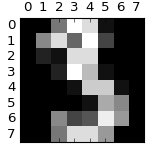

In [6]:
display_image_nb(digits.images[3])

Remarquons enfin que les images sont aussi disponnibles en format "plat" (flatten), dans le tableau digits.data

In [7]:
digits.images[3].flatten()

array([  0.,   0.,   7.,  15.,  13.,   1.,   0.,   0.,   0.,   8.,  13.,
         6.,  15.,   4.,   0.,   0.,   0.,   2.,   1.,  13.,  13.,   0.,
         0.,   0.,   0.,   0.,   2.,  15.,  11.,   1.,   0.,   0.,   0.,
         0.,   0.,   1.,  12.,  12.,   1.,   0.,   0.,   0.,   0.,   0.,
         1.,  10.,   8.,   0.,   0.,   0.,   8.,   4.,   5.,  14.,   9.,
         0.,   0.,   0.,   7.,  13.,  13.,   9.,   0.,   0.])

In [8]:
digits.data[3]

array([  0.,   0.,   7.,  15.,  13.,   1.,   0.,   0.,   0.,   8.,  13.,
         6.,  15.,   4.,   0.,   0.,   0.,   2.,   1.,  13.,  13.,   0.,
         0.,   0.,   0.,   0.,   2.,  15.,  11.,   1.,   0.,   0.,   0.,
         0.,   0.,   1.,  12.,  12.,   1.,   0.,   0.,   0.,   0.,   0.,
         1.,  10.,   8.,   0.,   0.,   0.,   8.,   4.,   5.,  14.,   9.,
         0.,   0.,   0.,   7.,  13.,  13.,   9.,   0.,   0.])

In [9]:
digits.data.shape

(1797, 64)

Le module sklearn (http://scikit-learn.org) offre un ensemble de fonctions permetant d'utiliser facilement des méthodes d'apprentissage automatisé.



In [10]:
import sklearn.svm

# création d'un classifieur de type SVM (support vector classifier)
classifier = sklearn.svm.SVC(gamma=0.0001)

# Apprentissage en utilisant la deuxième moitiée de la base de donnée
index = digits.data.shape[0]/2
X = digits.data[index:, :]
Y = digits.target[index:]
classifier.fit(X,Y)

# Maintenant on va utiliser le classifieur pour "prédire" 
# les valeurs présentes dans la première partie de la base de donnée
predicted = classifier.predict(digits.data[:index])
expected = digits.target[:index]


Quelle est la valeur prédite pour le chiffre à la position 15, quelle est la valeur attendue ? La prédiction est t'elle correcte ? Afficher l'image correspondante

Même question l'image à la position 120.

<IPython.core.display.Javascript object>


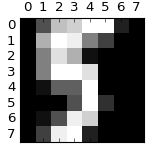

Valeur prédite pour le chiffre à la position 15 = 5, valeur attendue 5


<IPython.core.display.Javascript object>


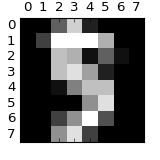

Valeur prédite pour le chiffre à la position 120 = 9, valeur attendue 5


In [11]:

i = 15
display_image_nb(digits.images[i])
print("Valeur prédite pour le chiffre à la position {} = {}, valeur attendue {}".format(i, predicted[i], expected[i]))

i = 120
display_image_nb(digits.images[i])
print("Valeur prédite pour le chiffre à la position {} = {}, valeur attendue {}".format(i, predicted[i], expected[i]))



### Analyse des performances.

La matrice de confusion permet de rapidement visualiser la qualité d'un système de classification. 

Le nom "confusion" vient du fait que cette matrice permet facilement de voir si deux classes peuvent être confondues (càd prédire une classe à la place d'une autre).

- ligne:  classe attendue
- colonne:  classe prédite.

Dans le cas d'un système parfait, toutes les valeurs se trouvent sur la diagonale.

Pour plus d'information: https://en.wikipedia.org/wiki/Confusion_matrix

In [12]:
from sklearn import metrics
print("Confusion matrix:\n{}".format(metrics.confusion_matrix(expected, predicted)))

Confusion matrix:
[[90  0  0  0  0  0  0  0  0  0]
 [ 0 90  0  0  0  0  1  0  0  0]
 [ 0  7 80  0  0  0  0  1  3  0]
 [ 0  0  0 84  0  0  0  0  7  1]
 [ 0  5  0  0 83  0  0  1  0  0]
 [ 0  0  0  0  0 86  0  0  2  3]
 [ 0  0  0  0  0  1 88  0  1  0]
 [ 0  0  0  0  1  2  0 85  0  2]
 [ 0  9  0  0  0  0  1  0 76  0]
 [ 0  5  0  0  2  0  0  4  3 74]]


En utilisant cette matrice de confusion, répondez au question suivantes:

- Combien de fois le chiffre 9 a été bien prédit ? (**True positive**, **HIT**)

In [13]:
74

74

- Combien de fois le chiffre 9 à été prédit alors qu'il s'agissait d'un autre chiffre ? (**False positive**)

In [14]:
1+3+2

6

- Combien de fois un chiffre autre que 9 a été prédit alors que le chiffre 9 était attendu ? (**False Negative**)

In [15]:
5+2+4+3

14

Precision et rappel (recall)

rappel = True positive / (True positive + False negative)
précision  = True positive / (True positive + False positive)


Une précision élevé implique qu'on ne se trompe pas quand on prédit une valeur (autrement dit on est sur de nous quand on donne une valeur).

Un rappel élevé signifie qu'on est capable de bien prédire un grand nombre des éléments qui nous interesse.

Remarque, il est facile d'avoir une précision élevé si on a un rappel très faible.

In [16]:
from sklearn import metrics
print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))


Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        90
          1       0.78      0.99      0.87        91
          2       1.00      0.88      0.94        91
          3       1.00      0.91      0.95        92
          4       0.97      0.93      0.95        89
          5       0.97      0.95      0.96        91
          6       0.98      0.98      0.98        90
          7       0.93      0.94      0.94        90
          8       0.83      0.88      0.85        86
          9       0.93      0.84      0.88        88

avg / total       0.94      0.93      0.93       898




Cross validation 



Apprendre sur des données et tester sur ces mêmes données est une erreur méthodologique. Il faut toujours évaluer les performances sur des données qui n'ont pas été utilisé pour l'apprentissage. Cette approche nécessite d'avoir un jeu de donnée d'apprentissage (X_learn, Y_learn) et un jeu de donnée de test (X_test, Y_test).

Cependant partitionner les données disponnibles en deux ensembles réduit drastiquement le nombre de données utilisé pour apprendre le modèle, et le résultat pourrait être dépendant du choix du partitionement.

Une solution est d'utiliser un schéma de type cross-validation.

k-fold cross validation:

- partitionner les données en k sous ensembles
pour i allant de 0 à k:
    - apprendre sur les sous ensembles [0, .., i-1, i+1, .. k]
    - tester sur le jeu de donnée i
- Moyenner les résultats



In [23]:
from sklearn import cross_validation
scores = cross_validation.cross_val_score(classifier, digits.data, digits.target, cv=10)
print(scores)

[ 0.93513514  0.9726776   0.94475138  0.95        0.95530726  0.98882682
  0.98324022  0.98876404  0.89830508  0.93181818]
